In [9]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

In [17]:
class RECIRCULATION:
    def __init__(self, neurons, act_funcs=relu, lr=1, reg=0.75, symmetric=False):
        if symmetric:
            neurons = neurons + neurons[-2:0:-1]

        self.neurons_ = np.array(neurons)
        self.layers_ = len(self.neurons_)
        
        if type(act_funcs) is not list:
            self.act_funcs_ = [act_funcs] * (self.layers_)
        elif len(act_funcs) == 2 and symmetric:
            self.act_funcs_ = [act_funcs[0]] * (self.layers_ // 2) + [act_funcs[1]] * (self.layers_ // 2)
        else:
            self.act_funcs_ = act_funcs
            print(act_funcs)
            
           
        if lr * 0 == 0:
            self.lr_ = np.array([lr] * len(neurons))
        else:
            self.lr_ = np.array(lr)

        if reg * 0 == 0:
            self.reg_ = np.array([reg] * len(neurons))
        else:
            self.reg_ = np.array(reg)
        
        # Initialize weight matrices in the interval [-0.5, 0.5]
        self.weights_ = []
        
        for i in range(self.layers_ - 1):
            self.weights_.append(np.random.random((self.neurons_[i] + 1, self.neurons_[i+1])) - 0.5)
        
        self.weights_.append(np.random.random((self.neurons_[-1] + 1, self.neurons_[0])) - 0.5)
        
    def recirculate(self, inputs, update=True):
        a = []
        for n in self.neurons_:
            a.append(np.ones((inputs.shape[0], 2, n + 1)))
            
        
        # First propagation
        a[0][:, 0, :-1] = inputs
        
        for i in range(self.layers_ - 1):
           
            a[i+1][:, 0, :-1] = self.act_funcs_[i](a[i][:, 0, :] @ self.weights_[i])
            
            
        # Second propagation
        a[0][:, 1, :-1] = self.reg_[0] * a[0][:, 0, :-1] + \
                          (1 - self.reg_[0]) * self.act_funcs_[-1](a[-1][:, 0, :] @ self.weights_[-1])
        for i in range(1, self.layers_):
            a[i][:, 1, :-1] = self.reg_[i] * a[i][:, 0, :-1] + \
                              (1 - self.reg_[i]) * self.act_funcs_[i-1](a[i-1][:, 1, :] @ self.weights_[i-1])
            
            
        # Perform weight updates
        for i in range(len(self.weights_) - 1):
            self.weights_[i] += self.lr_[i] * a[i][:, 1, :].T @ (a[i+1][:, 0, :-1] - a[i+1][:, 1, :-1])
        self.weights_[-1] += self.lr_[-1] * a[-1][:, 0, :].T @ (a[0][:, 0, :-1] - a[0][:, 1, :-1])
        
        return 0.5 * ((inputs - a[0][:, 1, :-1]) ** 2).sum()
    
    def encode(self, inputs, layer):
        a = []
        for n in self.neurons_:
            a.append(np.ones((inputs.shape[0], n + 1)))
        
        # First propagation
        a[0][:, :-1] = inputs
        for i in range(self.layers_ - 1):
            
            a[i+1][:, :-1] = self.act_funcs_[i](a[i][:, :] @ self.weights_[i])
            
        
        return a[layer][:, :-1], self.act_funcs_[-1](a[-1][:, :] @ self.weights_[-1])

In [18]:
def logistic(x):
    return 1 / (1 + np.exp(-x))

def tanh(x):
    return np.tanh(x)


def relu(x):
    return np.maximum(0, x)

[<function tanh at 0x114559170>, <function relu at 0x11452d830>]
[[-0.5421948  -0.73908903]
 [ 0.70063829  0.77192334]
 [-0.75143505  0.44832   ]
 [ 0.7185087  -0.45557125]]


<IPython.core.display.Javascript object>


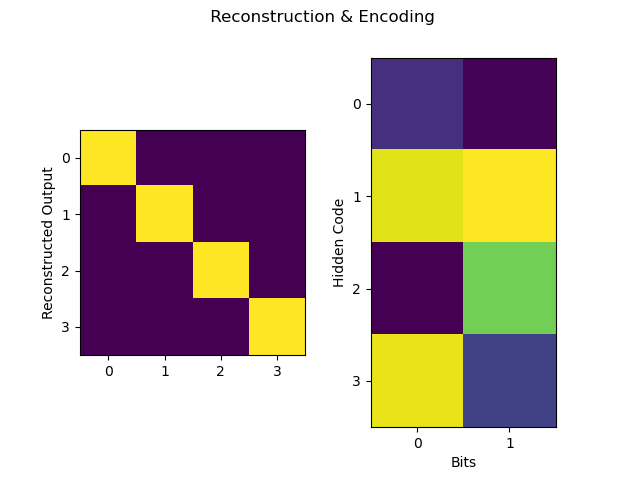

In [26]:
autoencoder = RECIRCULATION(neurons=[4, 2], act_funcs=[tanh, relu], lr=1, reg=[0.75, 0])

inputs = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]])

error = np.empty(200)
for i in range(200):
    error[i] = autoencoder.recirculate(inputs)
    
    
coded, recon = autoencoder.encode(inputs, layer=1)
print(coded)
fig = plt.figure()
fig.suptitle(' Reconstruction & Encoding')
axes = fig.subplots(1, 2)
axes[0].imshow(recon)
axes[0].set_ylabel('Reconstructed Output')
axes[0].set_xticks([0, 1, 2, 3])
axes[0].set_yticks([0, 1, 2, 3])
axes[1].imshow(coded)
axes[1].set_ylabel('Hidden Code')
axes[1].set_xlabel('Bits')
axes[1].set_yticks([0, 1, 2, 3])
axes[1].set_xticks([0, 1])
plt.show()    
    